In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

In [ ]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import xml.etree.ElementTree as ET

# Step 1: Define the parse_xml function
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text

    annotations = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox_tag = obj.find('bndbox')
        bbox = [
            int(bbox_tag.find('xmin').text),
            int(bbox_tag.find('ymin').text),
            int(bbox_tag.find('xmax').text),
            int(bbox_tag.find('ymax').text)
        ]
        annotations.append({'filename': filename, 'label': label, 'bbox': bbox})

    return annotations

# Step 2: Update the annotation path to Google Drive
ANNOTATION_PATH = '/content/drive/MyDrive/face-mask-detection/annotations'

# Step 3: Process the XML files
xml_files = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(ANNOTATION_PATH) if filename.endswith('.xml')]

data = []
for xml_file in xml_files:
    annotations = parse_xml(xml_file)

    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])

# Step 4: Display the label counts
print("📊 Label distribution:")
print(df['label'].value_counts())


Mounted at /content/drive
📊 Label distribution:
label
with_mask                1025
without_mask              256
mask_weared_incorrect      35
Name: count, dtype: int64


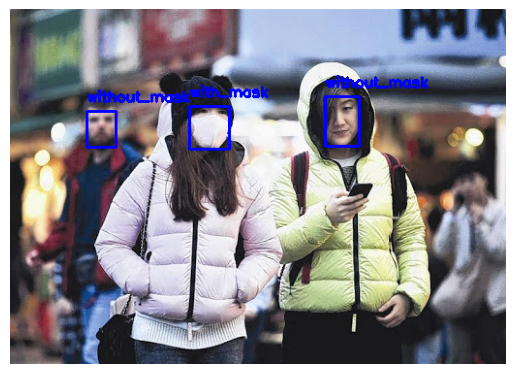

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Updated visualize_annotation function
def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)

    for ann in annotations:
        bbox = ann['bbox']
        # draw rectangle
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
        # put label
        cv2.putText(image, ann['label'], (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Paths for image and corresponding XML file
image_file = '/content/drive/MyDrive/face-mask-detection/images/maksssksksss0.png'
xml_file = '/content/drive/MyDrive/face-mask-detection/annotations/maksssksksss0.xml'

# Call the function with parsed annotation
visualize_annotation(image_file, parse_xml(xml_file))


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ✅ Updated image path
IMAGE_PATH = '/content/drive/MyDrive/face-mask-detection/images/'

# Label encoding
label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}

face_images = []
face_labels = []

# Process each row in the DataFrame
for i in range(len(df)):
    row = df.iloc[i]
    bbox = row['bbox']  # This is [xmin, ymin, xmax, ymax]

    # Construct full image path
    full_image_path = os.path.join(IMAGE_PATH, row['filename'])

    # Load and crop image
    image = cv2.imread(full_image_path)
    if image is None:
        print(f"⚠️ Warning: Couldn't read image {row['filename']}")
        continue

    xmin, ymin, xmax, ymax = bbox
    face = image[ymin:ymax, xmin:xmax]

    # Resize and preprocess
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)

    # Append to lists
    face_images.append(face)
    face_labels.append(label_pair[row['label']])

# Convert to NumPy arrays
face_images = np.array(face_images, dtype='float32')
face_labels = np.array(face_labels)


⚠️ Warning: Couldn't read image maksssksksss261.png
⚠️ Warning: Couldn't read image maksssksksss261.png
⚠️ Warning: Couldn't read image maksssksksss261.png
⚠️ Warning: Couldn't read image maksssksksss261.png
⚠️ Warning: Couldn't read image maksssksksss261.png
⚠️ Warning: Couldn't read image maksssksksss261.png
⚠️ Warning: Couldn't read image maksssksksss263.png
⚠️ Warning: Couldn't read image maksssksksss263.png
⚠️ Warning: Couldn't read image maksssksksss263.png
⚠️ Warning: Couldn't read image maksssksksss262.png


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmentation = ImageDataGenerator(
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=25,
    fill_mode='nearest'
)


In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(
    face_images, face_labels,
    test_size=0.2,
    shuffle=True,
    stratify=face_labels
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3

# Load InceptionV3 without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom classification head
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)  # 3 classes: with, without, incorrect

# Combine into full model
model = tf.keras.Model(inputs=base_model.input, outputs=x)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    augmentation.flow(train_x, train_y, batch_size=16),
    validation_data = (test_x, test_y),
    epochs = 20
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.6094 - loss: 16.4152 - val_accuracy: 0.9084 - val_loss: 0.8627
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.8193 - loss: 1.0513 - val_accuracy: 0.8321 - val_loss: 0.6259
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.8645 - loss: 0.6056 - val_accuracy: 0.8588 - val_loss: 0.7918
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.8831 - loss: 0.4648 - val_accuracy: 0.9351 - val_loss: 0.2767
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.9273 - loss: 0.3003 - val_accuracy: 0.9008 - val_loss: 0.3523
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.9075 - loss: 0.3698 - val_accuracy: 0.8168 - val_loss: 0.5507
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.8880 - loss: 0.4569 - val_accuracy: 0.9351 - val_loss: 0.4165
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.9270 - loss: 0.2942 - val_accuracy: 0.9504 - 

In [ ]:
model.save('mask_detection.h5')

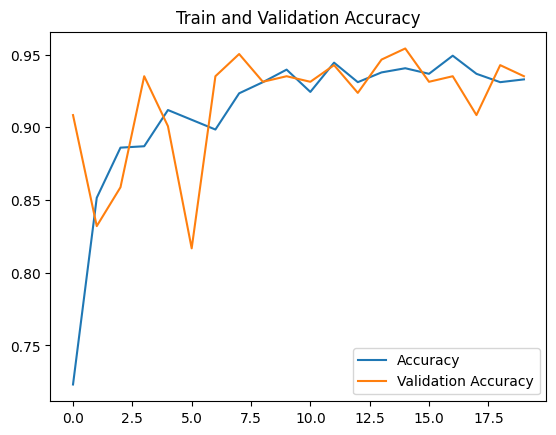

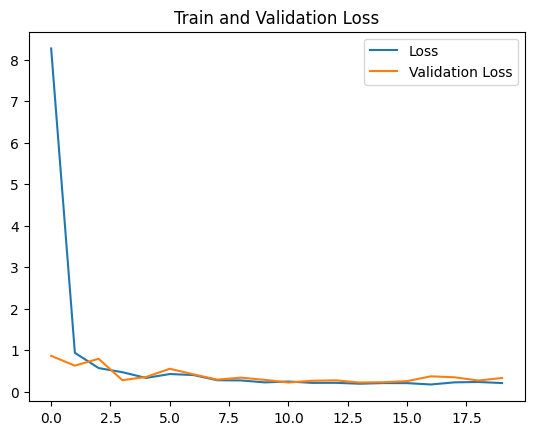

In [ ]:
plt.figure()
plt.title('Train and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('Train and Validation Loss')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Download both files into Google Drive
!wget -O /content/drive/MyDrive/face-mask-detection/deploy.prototxt https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -O /content/drive/MyDrive/face-mask-detection/res10_300x300_ssd_iter_140000.caffemodel https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel


--2025-06-24 18:58:34--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘/content/drive/MyDrive/face-mask-detection/deploy.prototxt’

/content/drive/MyDr 100%[===================>]  27.45K  --.-KB/s    in 0.002s  

2025-06-24 18:58:34 (14.6 MB/s) - ‘/content/drive/MyDrive/face-mask-detection/deploy.prototxt’ saved [28104/28104]

--2025-06-24 18:58:35--  https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


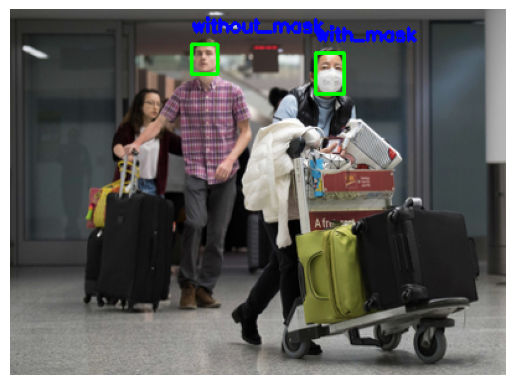

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# ✅ Paths in your mounted Google Drive
model_path = "/content/drive/MyDrive/face-mask-detection/deploy.prototxt"
weights_path = "/content/drive/MyDrive/face-mask-detection/res10_300x300_ssd_iter_140000.caffemodel"

# ✅ Load OpenCV face detection model
face_net = cv2.dnn.readNetFromCaffe(model_path, weights_path)

# ✅ Reverse label mapping
label_pair_reversed = {
    0: 'with_mask',
    1: 'without_mask',
    2: 'mask_weared_incorrect'
}

# ✅ Prediction function
def predict_image(filepath):
    image = cv2.imread(filepath)
    if image is None:
        print(f"❌ Image not found at {filepath}")
        return
    (h, w) = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.2:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            face = image[startY:endY, startX:endX]
            if face.size == 0:
                continue

            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = tf.expand_dims(face, axis=0)
            face = preprocess_input(face)

            label = model.predict(face)
            label = np.argmax(label, axis=1)[0]

            cv2.putText(image, label_pair_reversed[label], (startX, startY - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# ✅ Example image path from Google Drive
predict_image('/content/drive/MyDrive/face-mask-detection/images/maksssksksss129.png')


In [ ]:
import os
print("📁 Contents of face-mask-detection folder:")
print(os.listdir('/content/drive/MyDrive/face-mask-detection'))

📁 Contents of face-mask-detection folder:
['images', 'annotations', 'deploy.prototxt', 'res10_300x300_ssd_iter_140000.caffemodel']
